In [1]:
# libraries
from customCLIP import customCLIP
import pandas as pd

/usr/local/Caskroom/miniconda/base/envs/EuroSAT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training models

When training models under few_shot learning, we have to select which setting we want to train under `MODE`, and the number of samples per class `FEW_SHOT`.

Additionally, we should set the following booleanparameters:
- `full_prompt`, when true will prepend "A satelite image of " to the textual prompt, otherwise just use class names
- `modify`, when true will replace the class names with more gramatically correct versions
- `augment_hue`, when true will augment the hue/contrast of the images for training

Valid `MODE`s: `linear_probe`, `mlp_probe`, `logreg_probe`, `coop`

In [5]:
FEW_SHOT = 8
MODE = "coop"

customclip = customCLIP(model_name="openai/clip-vit-base-patch32", full_prompt=True, modify=True,augment_hue=True)
customclip.train(few_shot=FEW_SHOT, mode="linear_probe", save_model=False)


Training linear probe with 4-shot data...
Epoch [0/1000] | Train Loss: 2.3411 | Val Loss 2.2905 | Val Acc: 16.80%
Epoch [250/1000] | Train Loss: 0.0724 | Val Loss 0.8817 | Val Acc: 72.80%
Epoch [500/1000] | Train Loss: 0.0241 | Val Loss 0.8501 | Val Acc: 72.80%
Epoch [750/1000] | Train Loss: 0.0125 | Val Loss 0.8490 | Val Acc: 72.60%
Epoch [1000/1000] | Train Loss: 0.0078 | Val Loss 0.8541 | Val Acc: 72.60%


### Testing from loaded models

Valid modes: `linear_probe`, `mlp_probe`, `logreg_probe`, `coop`

In [6]:
FEW_SHOT = 8
MODE = "coop"
IMAGE_PATH = "2750/Forest/Forest_109.jpg"

customclip = customCLIP(model_name="openai/clip-vit-base-patch32")

if MODE == "coop":
    model_path = f"models/prompt_learners/coop/{FEW_SHOT}_shot.pth"
    customclip.load_model(model_path, mode=MODE)
elif MODE in ["linear_probe", "MLP_probe", "logreg_probe"]:
    model_path = f"results/classifiers/{MODE}/{FEW_SHOT}-shot"
    customclip.load_model(model_path, mode=MODE)
elif MODE == "zeroshot":
    pass

customclip.set_testing_mode(MODE)


Loaded coop model from models/prompt_learners/coop/8_shot.pth
Testing in coop mode


#### Single Image Classification

In [4]:
prediction, prob, _ = customclip.classify_images_clip([IMAGE_PATH])
print(f"Prediction: {customclip.class_labels[prediction.item()]} (Class {prediction.item()}) with probability {prob.item()}")

Loaded coop model from models/prompt_learners/coop/8_shot.pth
Testing in coop mode
Prediction: Forest (Class 1) with probability 0.9504203796386719


#### Single Class Classification

Classnames:
- `AnnualCrop`
- `Forest`
- `HerbaceousVegetation`
- `Highway`
- `Industrial`
- `Pasture`
- `PermanentCrop`
- `Residential`
- `River`
- `SeaLake`

In [8]:
EVAL_CLASS = "Forest"

results = customclip.single_class_analysis(EVAL_CLASS)
results["accuracy"]

Classifying Forest batches: 100%|██████████| 47/47 [00:18<00:00,  2.48it/s]


0.8266666666666667

#### Multi-class Classification

In [9]:
results = customclip.multi_class_analysis()
results["accuracy"].mean()

Testing dataset using coop method


Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


0.8190966666666668

### Plotting

#### Plotting func 

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def classifiers_accuracies(mode, path, zero_shot_accs):
    
    # Define few-shot settings
    few_shot_settings = [1, 2, 4, 8, 16]

    # Load results into a dictionary
    accuracy_per_class = {}

    for few_shot in few_shot_settings:
        results_df = pd.read_csv(f"{path}/{few_shot}-shot")
        accuracy_per_class[few_shot] = list(results_df.accuracy)  # Assuming accuracy is per class

        average_few_shot_accuracy = results_df.accuracy.mean()
        accuracy_per_class[few_shot].insert(0, average_few_shot_accuracy)
    
    CLASSES = results_df["class"].tolist()

    # Prepare the x positions
    x = np.arange(len(CLASSES) + 1)  # Add one for the "Average" bar

    plt.figure(figsize=(20, 5))

    # Bar widths
    bar_width = 0.15

    # Plot each few-shot setting with adjusted positions
    plt.bar(x - 3.0 * bar_width, zero_shot_accs, width=bar_width, label="0-shot", alpha=0.7)
    plt.bar(x - 2.0 * bar_width, accuracy_per_class[1], width=bar_width, label="1-shot", alpha=0.7)
    plt.bar(x - 1.0 * bar_width, accuracy_per_class[2], width=bar_width, label="2-shot", alpha=0.7)
    plt.bar(x, accuracy_per_class[4], width=bar_width, label="4-shot", alpha=0.7)
    plt.bar(x + 1 * bar_width, accuracy_per_class[8], width=bar_width, label="8-shot", alpha=0.7)
    plt.bar(x + 2.0 * bar_width, accuracy_per_class[16], width=bar_width, label="16-shot", alpha=0.7)

    plt.xticks(x, ["Average"] + CLASSES, rotation=45, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{mode} Comparison of Class Accuracies")
    plt.legend()
    plt.show()

    return accuracy_per_class, CLASSES

# Call the function with a specific mode


#### Zero-Shot Accuracies

In [10]:
customclip = customCLIP()
customclip.set_testing_mode("zeroshot")

zero_shot_results = customclip.multi_class_analysis()


Testing in zeroshot mode
Testing dataset using zeroshot method


Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.59it/s]


In [36]:
zero_shot_accuracies = list(results['accuracy'])


average_few_shot_accuracy = np.mean(zero_shot_accuracies)
zero_shot_accuracies.insert(0, average_few_shot_accuracy)

#### Linear Probe Accuracies

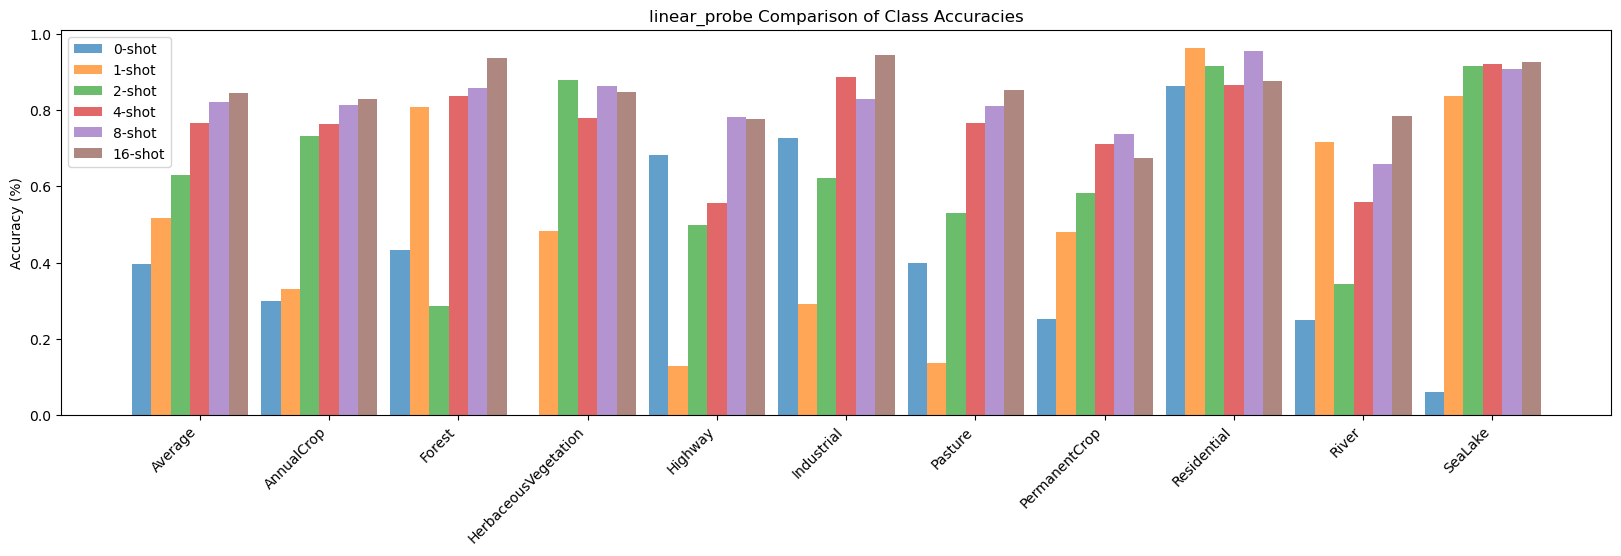

In [37]:
_ = classifiers_accuracies('linear_probe', "results/classifiers/linear_probe", zero_shot_accuracies)

#### MLP Probe Accuracies

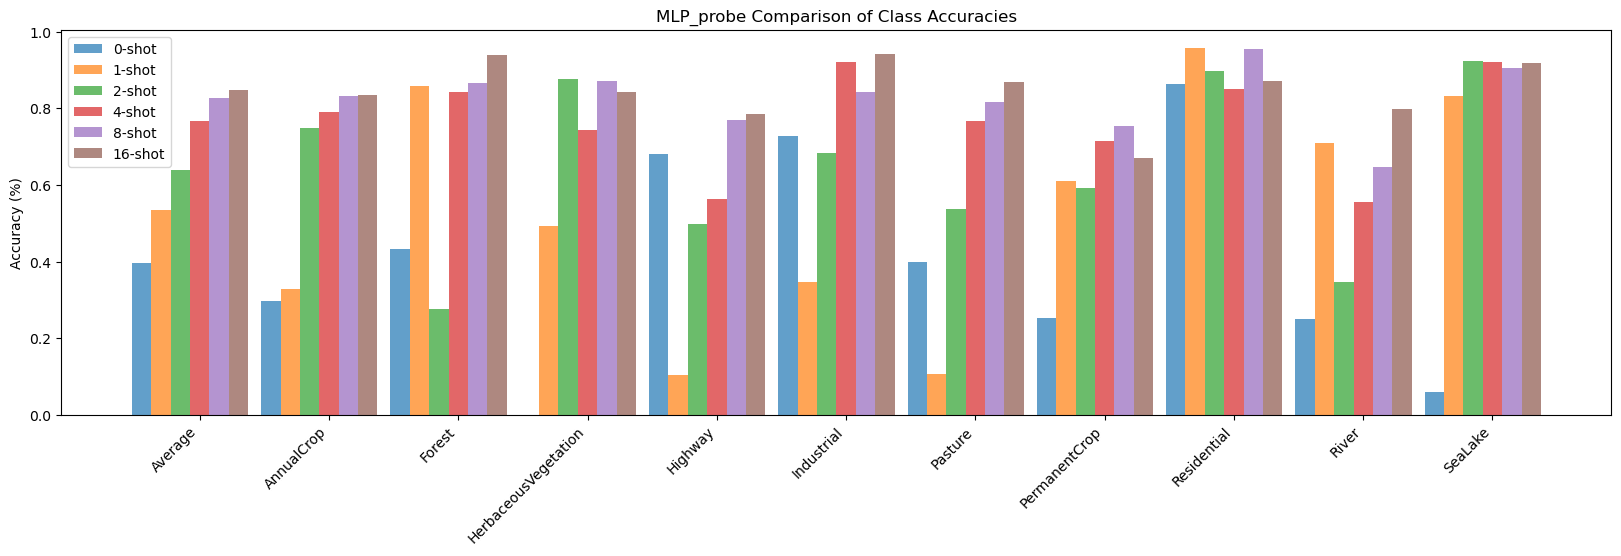

In [38]:
_ = classifiers_accuracies("MLP_probe", "results/classifiers/MLP_probe", zero_shot_accuracies)

#### Logreg Probe Accuracies

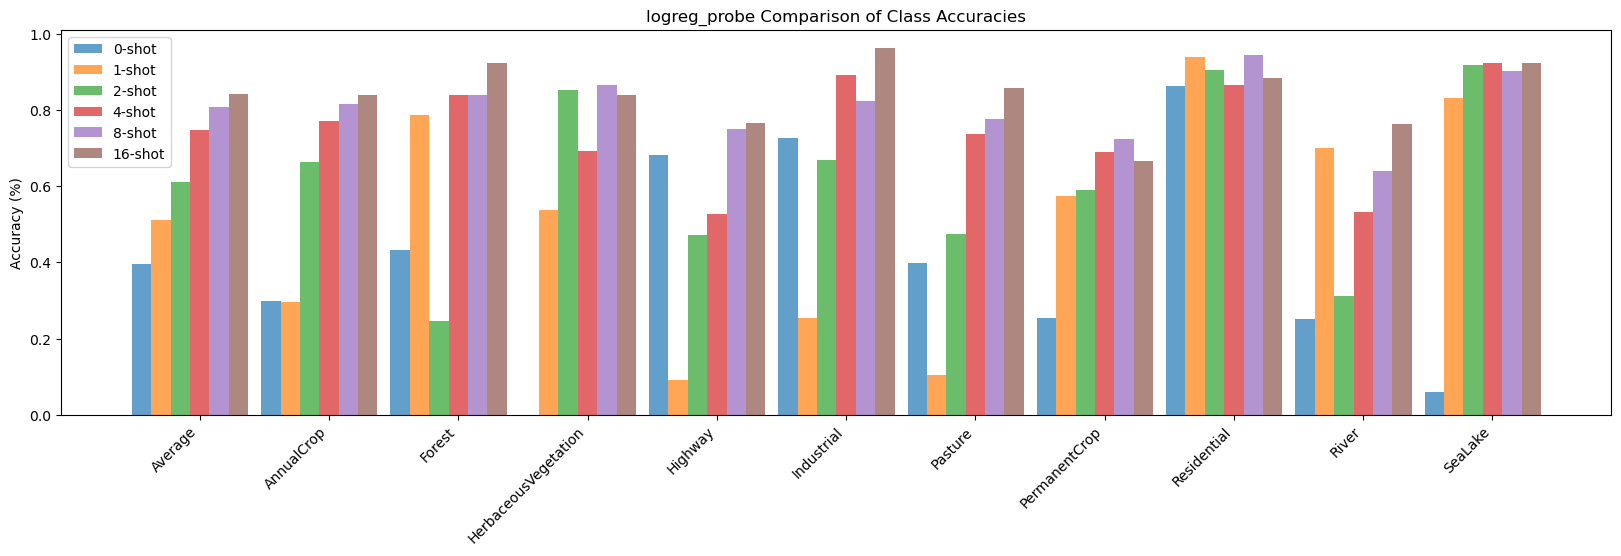

In [39]:
_ = classifiers_accuracies("logreg_probe", "results/classifiers/logreg_probe", zero_shot_accuracies)

#### CoOp Accuracies

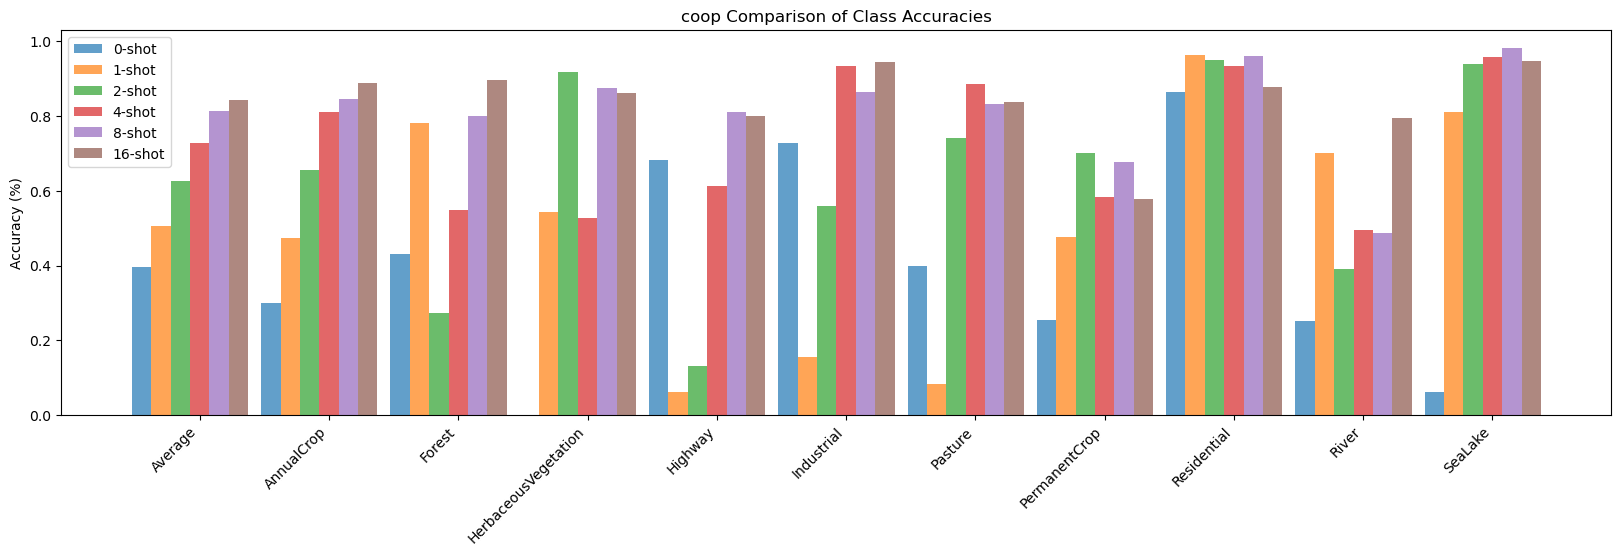

In [40]:
_ = classifiers_accuracies("coop", "results/coop", zero_shot_accuracies)

#### Average Accuracy Comparisons

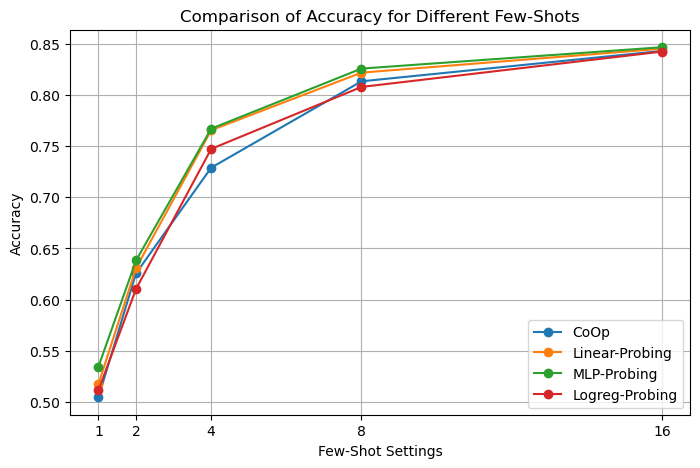

In [114]:
few_shot_settings = [1, 2, 4, 8, 16]

# Load results into a dictionary
accuracy_per_class = {}

for few_shot in few_shot_settings:
    coop_results_df = pd.read_csv(f"results/coop/{few_shot}-shot")
    linear_results_df = pd.read_csv(f"results/classifiers/linear_probe/{few_shot}-shot")
    mlp_results_df = pd.read_csv(f"results/classifiers/mlp_probe/{few_shot}-shot")
    logreg_results_df = pd.read_csv(f"results/classifiers/logreg_probe/{few_shot}-shot")

    accuracy_per_class[few_shot] = [coop_results_df.accuracy.mean(), linear_results_df.accuracy.mean(), mlp_results_df.accuracy.mean(), logreg_results_df.accuracy.mean()]

# Extracting keys and values for plotting
x = list(accuracy_per_class.keys())
y_values = list(zip(*accuracy_per_class.values()))  # Transposing the values to separate the two series

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, y_values[0], label="CoOp", marker='o')
plt.plot(x, y_values[1], label="Linear-Probing", marker='o')
plt.plot(x, y_values[2], label="MLP-Probing", marker='o')
plt.plot(x, y_values[3], label="Logreg-Probing", marker='o')

plt.xlabel("Few-Shot Settings")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy for Different Few-Shots")
plt.legend()
plt.grid(True)
plt.xticks(x)

plt.show()
